In [1]:
import sys
import os
import gymnasium as gym
from PIL import Image
import random
import re
import math
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
random.seed(123456)

In [2]:
# Forced to do this since gymnasium does not expose grid information
custom_map = [
    'SFFFFFFF',
    'FFFFFFFF',
    'FFFHFFFF',
    'FFFFFHFF',
    'FFFHFFFF',
    'FHHFFFHF',
    'FHFFHFHF',
    'FFFHFFFG'
]

# Identical recreation of map_name='8X8'
env = gym.make('FrozenLake-v1', desc=custom_map, render_mode="rgb_array")

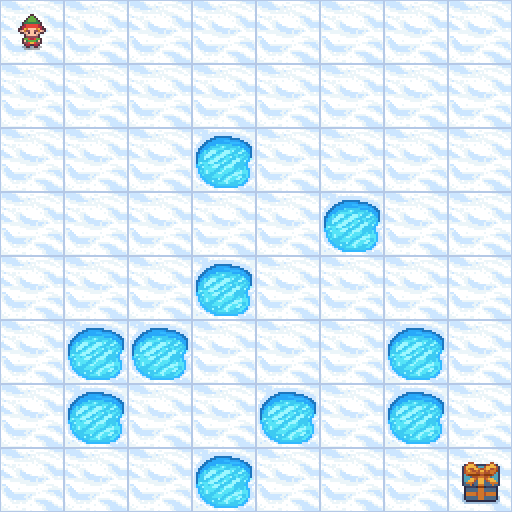

In [3]:
env.reset()
Image.fromarray(env.render())

## Environment setup - creating an environment that matches what Gym gives us

In [4]:
terminated = False
env.reset()
im_init = Image.fromarray(env.render())
viz = []
while not terminated:
    s_prime, r, terminated, _, _ = env.step(random.randint(0,3))
    rendered = env.render()
    viz.append(Image.fromarray(rendered))


im_init.save("random_policy.gif", save_all=True, append_images=viz, duration=20 * (len(viz) + 1), loop=0)

In [5]:
# Basically re-creating frozen lake from scratch... there is no way to get any global environment information 
def board_num_to_coords(num, width, height):
    curr_height = int(num / width)
    return curr_height, num - (curr_height * width)
    
def coords_to_board_num(vertical, horizontal, width):
    return width * vertical + horizontal

def is_goal(vertical, horizontal, board):
    return board[vertical][horizontal] == 'G'

def is_hole(vertical, horizontal, board):
    return board[vertical][horizontal] == 'H'

def is_terminal(vertical, horizontal, board):
    return is_goal(vertical, horizontal, board) or is_hole(vertical, horizontal, board)
        
def is_valid(vertical, horizontal, board):
        return vertical >= 0 and vertical < len(board) and \
               horizontal >= 0 and horizontal < len(board[0])

def move(vertical, horizontal, action):
    """Maps action to new board position, given current board position"""
    if action == 0: return vertical, horizontal - 1 # Left 
    elif action == 1: return vertical + 1, horizontal # Down
    elif action == 2: return vertical, horizontal + 1 # Right
    else: return vertical - 1, horizontal # Up

def adjacent_directions(action):
    """To model 'slipperiness' of environment"""
    if action == 0: return (0, 1, 3) # left = left/down/up
    elif action == 1: return (0, 1, 2) # down = down/left/right
    elif action == 2: return (1, 2, 3) # # right = right/down/up
    else: return (0, 2, 3) # Up = up/left/right

In [6]:
def get_transition_probabilities(board):
    """Transition probabilities for T(s, a, s')"""
    transition_probabilities = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
    height = len(board)
    width = len(board[0])

    for state in range(height * width):
        v, h = board_num_to_coords(state, width, height)
        if is_terminal(v, h, board):
            for action in range(4):
                transition_probabilities[state][action][state] = 1.0
        else:
            for action in range(4):
                for potential_movements in adjacent_directions(action):
                    new_v, new_h = move(v, h, potential_movements)
                    new_state = coords_to_board_num(new_v, new_h, width) if is_valid(new_v, new_h, board) else state
                    transition_probabilities[state][action][new_state] += 1/3
                    
    return transition_probabilities

def get_rewards(board):
    """Any state to terminal non-goal state is -1.0."""
    width = len(board[0])
    height = len(board)
    
    rewards = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
    for state in range(width * height):
        v, h = board_num_to_coords(state, width, height)
        if not is_terminal(v, h, board):
            for action in range(4):
                for new_state in range(width * height):
                    new_v, new_h = board_num_to_coords(new_state, width, height)
                    if state != new_state:
                        if is_hole(new_v, new_h, board):
                            rewards[state][action][new_state] = -1.0
                        elif is_goal(new_v, new_h, board):
                            rewards[state][action][new_state] = 1.0
    return rewards

In [7]:
transition_probabilities = get_transition_probabilities(custom_map)
rewards = get_rewards(custom_map)

In [8]:
dict(transition_probabilities[62][3])

{61: 0.3333333333333333, 63: 0.3333333333333333, 54: 0.3333333333333333}

In [9]:
dict(rewards[62][2])

{19: -1.0,
 29: -1.0,
 35: -1.0,
 41: -1.0,
 42: -1.0,
 46: -1.0,
 49: -1.0,
 52: -1.0,
 54: -1.0,
 59: -1.0,
 63: 1.0}

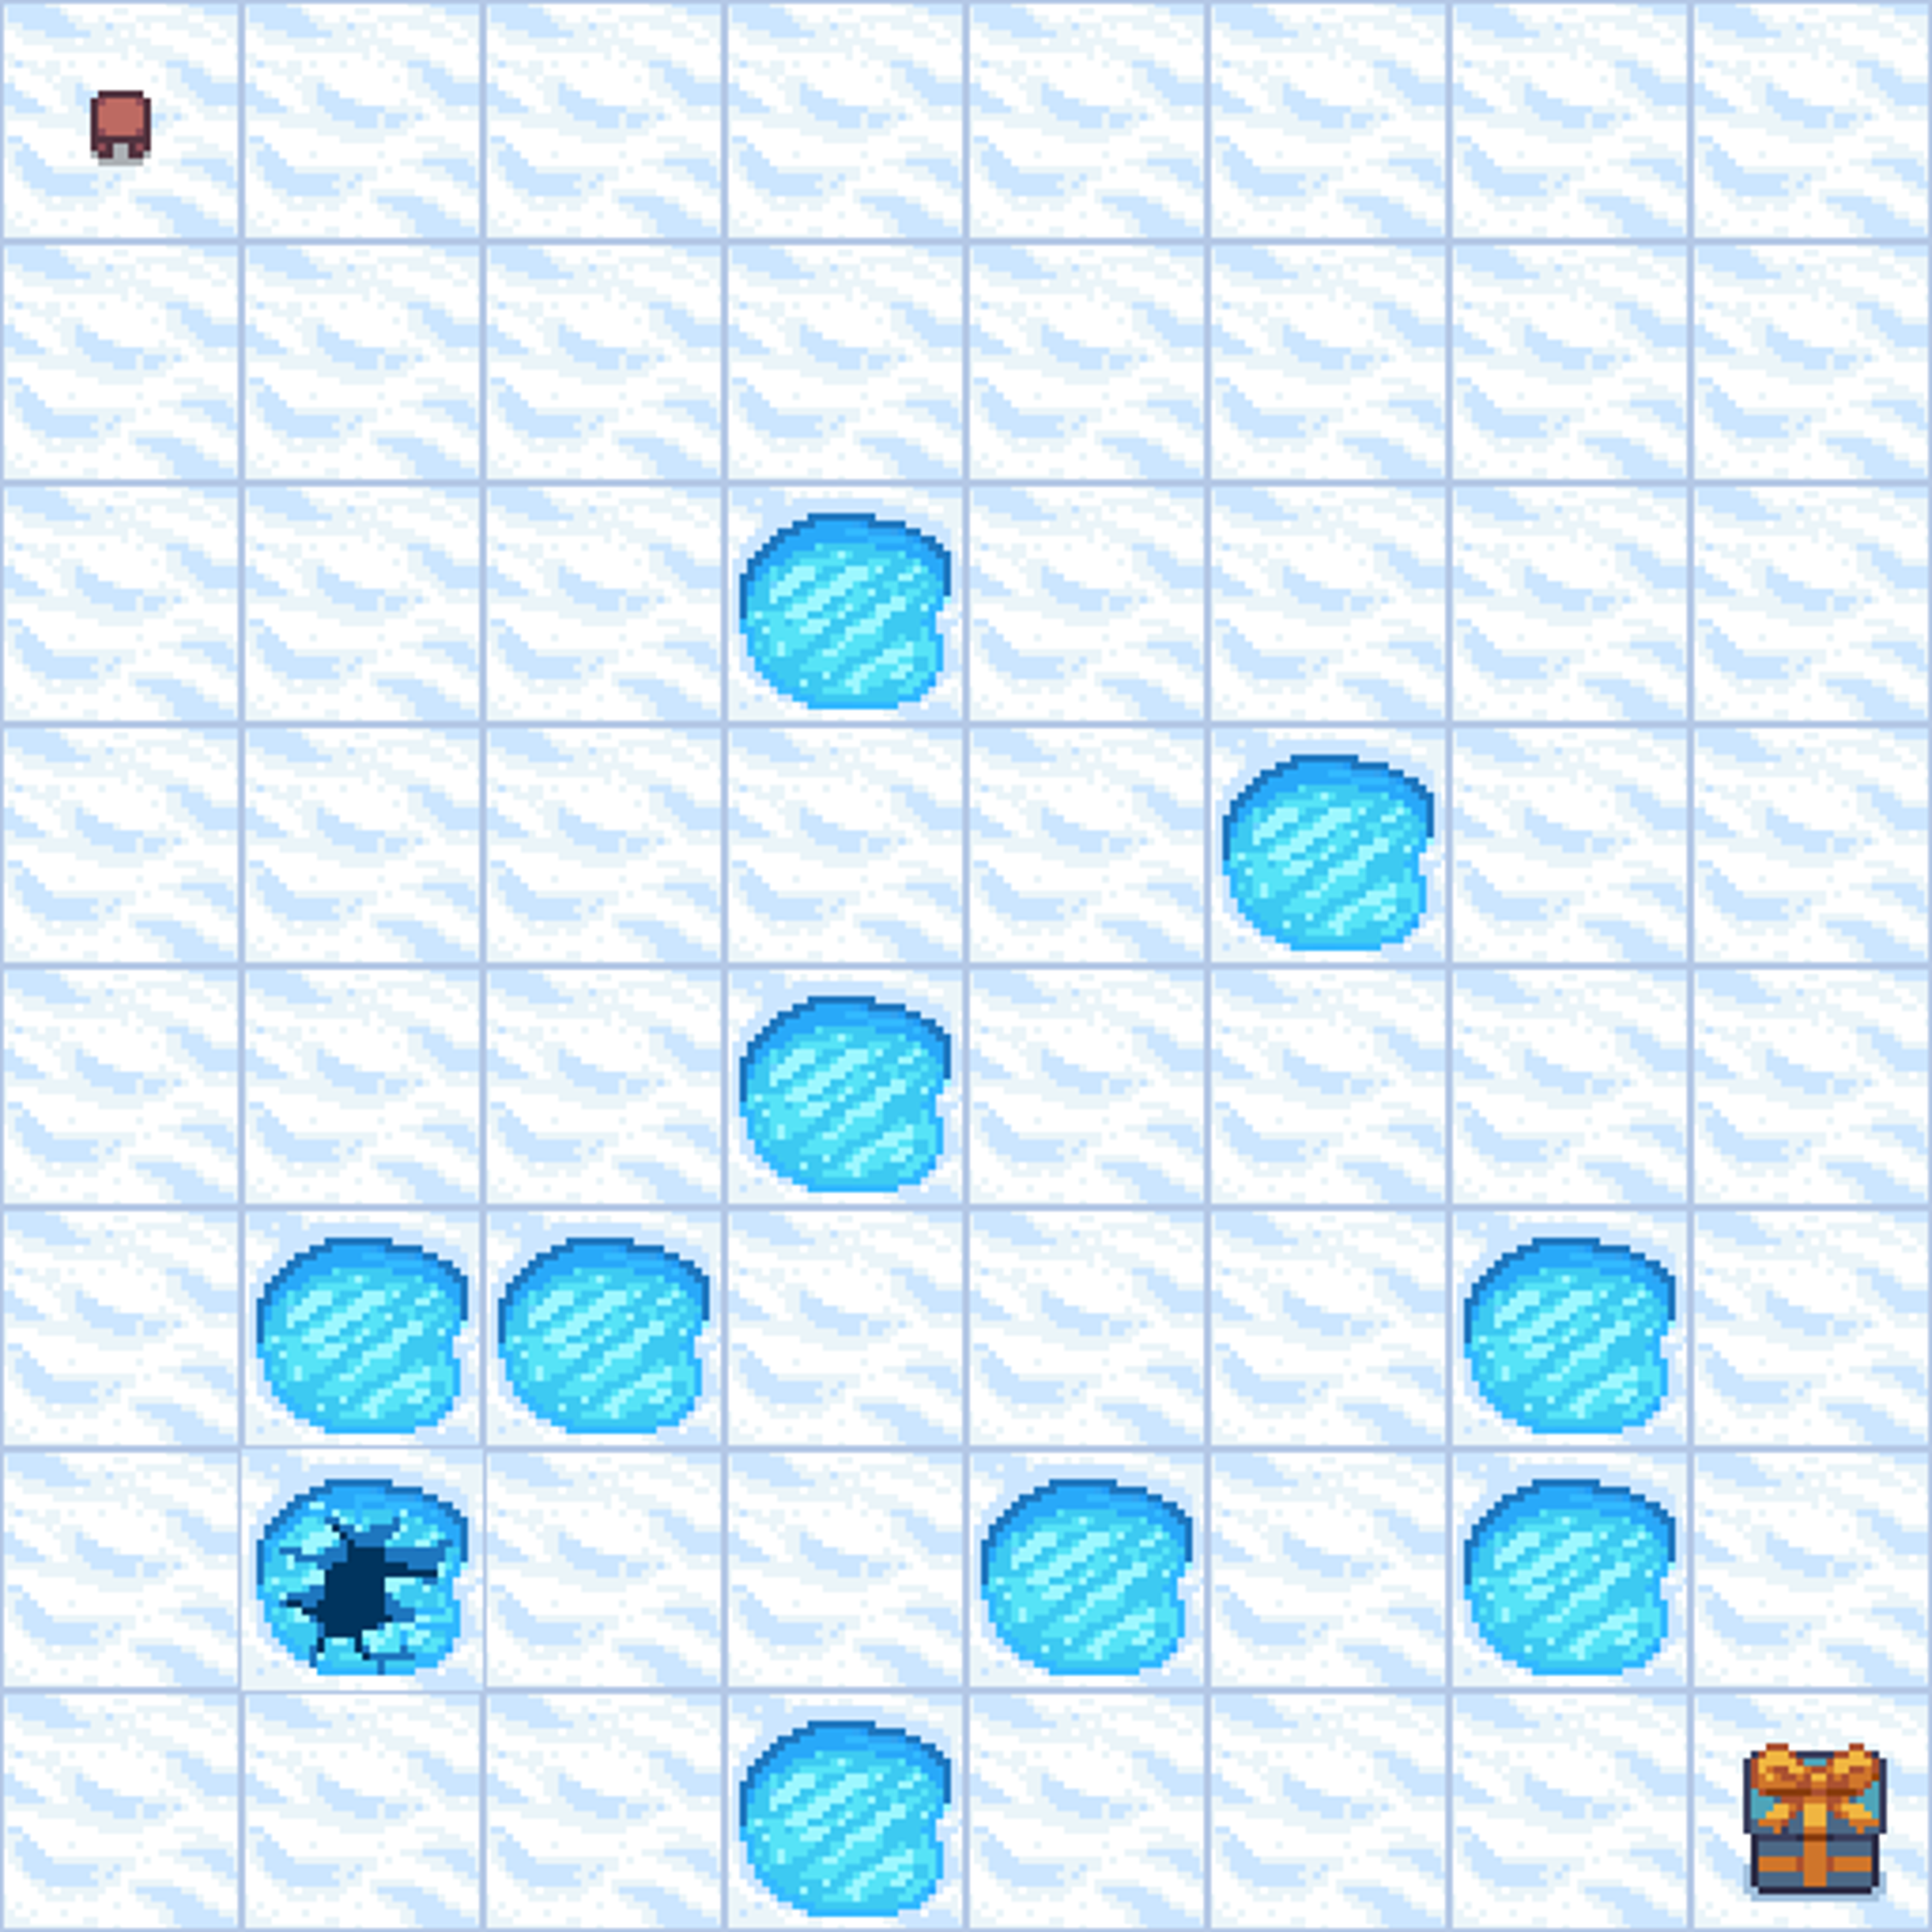

In [10]:
Image.fromarray(env.render()).resize((3200, 3200))

## Value iteration

In [11]:
def value_iteration(T, R, num_states, num_actions, convergence_threshold =0.00001, gamma=0.9999):
    start = True
    max_diff = 0.0
    values = [0.0] * num_states
    best_actions = [0] * num_states
    num_iter = 0
    while start or max_diff > convergence_threshold:
        max_diff = 0.0
        num_iter += 1
        start = False
        old_values = values.copy()
        
        for state in range(num_states):
            best_action, best_action_value = -1, -sys.maxsize
            for action in range(num_actions):
                action_value = 0.0
                for next_state, transition_probability in dict(T[state][action]).items():
                    action_value += (R[state][action][next_state] + (gamma * old_values[next_state])) * transition_probability
                if action_value > best_action_value:
                    best_action_value = action_value
                    best_action = action
            
            values[state] = best_action_value
            best_actions[state] = best_action
            max_diff = max(max_diff, abs(old_values[state] - values[state]))
        
    return values, best_actions, num_iter

In [12]:
width = len(custom_map[0])
height = len(custom_map)
num_states = width * height
num_actions = 4

In [13]:
vi_values, vi_policy, vi_num_iter = value_iteration(transition_probabilities, rewards, num_states, num_actions)
vi_value_grid = np.array(vi_values).reshape(height, width)
vi_action_grid = np.array(vi_policy).reshape(height, width)

In [14]:
print(vi_num_iter)

643


In [15]:
vi_action_grid

array([[3, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 2],
       [0, 0, 0, 0, 2, 3, 3, 2],
       [0, 0, 0, 3, 0, 0, 2, 2],
       [0, 3, 0, 0, 2, 1, 3, 2],
       [0, 0, 0, 1, 3, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 0, 0, 1, 2, 1, 0]])

In [16]:
# Visualize policy based on value iteration
def apply_map(in_):
    visual_action_map = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    return visual_action_map[in_]

f = np.vectorize(apply_map)
vi_arrows = f(vi_action_grid)

In [17]:
np.round(vi_value_grid, 2)

array([[ 0.99,  0.99,  0.99,  0.99,  0.99,  0.99,  0.99,  0.99],
       [ 0.99,  0.99,  0.99,  0.99,  0.99,  0.99,  0.99,  0.99],
       [ 0.99,  0.94,  0.84,  0.  ,  0.7 ,  0.88,  0.96,  0.99],
       [ 0.98,  0.86,  0.59, -0.06,  0.24,  0.  ,  0.88,  0.99],
       [ 0.98,  0.64,  0.08,  0.  ,  0.07,  0.22,  0.7 ,  0.99],
       [ 0.98,  0.  ,  0.  , -0.67, -0.24, -0.12,  0.  ,  1.  ],
       [ 0.98,  0.  , -0.61, -0.76,  0.  , -0.34,  0.  ,  1.  ],
       [ 0.98,  0.45, -0.08,  0.  , -0.45,  0.11,  0.55,  0.  ]])

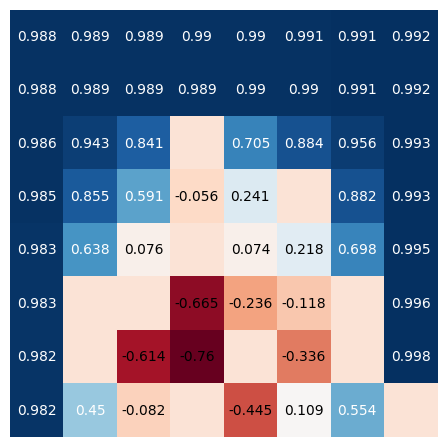

In [18]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(figsize=(5,5))
fig.tight_layout()
im = ax.imshow(vi_value_grid, cmap=plt.cm.RdBu)
for i in range(len(vi_arrows)):
    for j in range(len(vi_arrows[0])):
        if not is_terminal(i, j, custom_map):
            text = ax.text(j, i, str(round(vi_value_grid[i, j], 3)), ha="center", va="center", color="white" if vi_value_grid[i, j] > 0.35 else 'black')
ax.axis('off')
plt.savefig('value_iteration_value_heatmap.png', bbox_inches='tight', pad_inches=0.0)

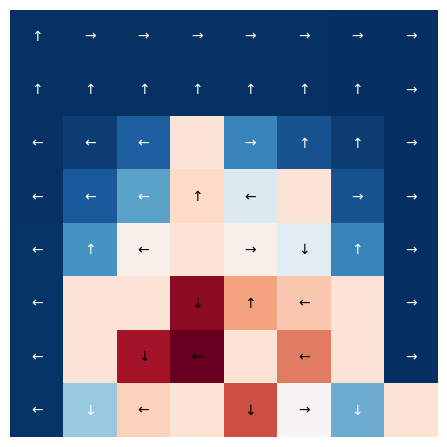

In [19]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(figsize=(5,5))
fig.tight_layout()
im = ax.imshow(vi_value_grid, cmap=plt.cm.RdBu)
for i in range(len(vi_arrows)):
    for j in range(len(vi_arrows[0])):
        if not is_terminal(i, j, custom_map):
            text = ax.text(j, i, vi_arrows[i, j], ha="center", va="center", color="white" if vi_value_grid[i, j] > 0.35 else 'black')
ax.axis('off')
plt.savefig('value_iteration_arrow_heatmap.png', bbox_inches='tight', pad_inches=0.0)

In [20]:
# Overlaid image - kind of bad looking blend, does the job
env.reset()
im1 = Image.fromarray(env.render()).resize((400,400))
im2 = Image.open('value_iteration_arrow_heatmap.png').convert("RGB").resize((400, 400))
Image.blend(im1, im2, alpha=.6).save('value_iteration_arrow_heatmap_overlaid.png')

## Policy iteration

In [21]:
def policy_evaluation(T, R, policy, values, num_states, gamma, convergence_threshold):
    delta = convergence_threshold + 1
    while delta > convergence_threshold:
        value_copy = values.copy()
        for state in range(num_states):
            action = policy[state]
            action_value = 0
            for other_state, probability in dict(T[state][action]).items():
                action_value += probability * (R[state][action][other_state] + gamma * value_copy[other_state])
            values[state] = action_value
        delta = max([abs(vc - v) for vc, v in zip(value_copy, values)])
    return values, delta

def policy_improvement(T, R, num_states, num_actions, old_policy, new_values, gamma):
    policy_stable = True
    new_policy = {}
    for state, action in old_policy.items():
        best_action, best_action_value = -1, -sys.maxsize
        for action in range(num_actions):
            action_value = 0.0
            for next_state, transition_probability in dict(T[state][action]).items():
                action_value += (R[state][action][next_state] + (gamma * new_values[next_state])) * transition_probability
            if action_value > best_action_value:
                best_action_value = action_value
                best_action = action
        new_policy[state] = best_action
        if new_policy[state] != old_policy[state]:
            policy_stable = False
    return new_policy, policy_stable

def policy_iteration(T, R, num_states, num_actions, convergence_threshold=0.00001, gamma=0.9999):
    policy = {s: random.randint(0,3) for s in range(num_states)}
    values = [0] * len(T)
    policy_stable = False
    num_iter = 0
    while not policy_stable:
        new_values, delta = policy_evaluation(T, R, policy, values, num_states, gamma, convergence_threshold)
        new_policy, policy_stable = policy_improvement(T, R, num_states, num_actions, policy, new_values, gamma)
        policy = new_policy
        values = new_values
        num_iter += 1
        print(f'Num iterations: {num_iter}')

    return values, policy

In [22]:
pi_values, pi_policy = policy_iteration(transition_probabilities, rewards, num_states, num_actions)
pi_value_grid = np.array(pi_values).reshape(height, width)

Num iterations: 1
Num iterations: 2
Num iterations: 3
Num iterations: 4
Num iterations: 5
Num iterations: 6
Num iterations: 7
Num iterations: 8
Num iterations: 9
Num iterations: 10


In [23]:
pi_action_grid = np.array(list(pi_policy.values())).reshape(height, width)

In [24]:
pi_action_grid

array([[3, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 2],
       [0, 0, 0, 0, 2, 3, 3, 2],
       [0, 0, 0, 1, 0, 0, 2, 2],
       [0, 3, 0, 0, 2, 1, 3, 2],
       [0, 0, 0, 1, 3, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 0, 2],
       [0, 1, 0, 0, 1, 2, 1, 0]])

In [25]:
pi_arrows = f(pi_action_grid)

In [26]:
pi_arrows

array([['↑', '→', '→', '→', '→', '→', '→', '→'],
       ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '→'],
       ['←', '←', '←', '←', '→', '↑', '↑', '→'],
       ['←', '←', '←', '↓', '←', '←', '→', '→'],
       ['←', '↑', '←', '←', '→', '↓', '↑', '→'],
       ['←', '←', '←', '↓', '↑', '←', '←', '→'],
       ['←', '←', '↓', '←', '←', '←', '←', '→'],
       ['←', '↓', '←', '←', '↓', '→', '↓', '←']], dtype='<U1')

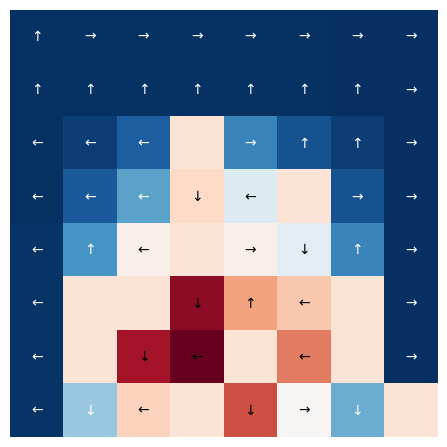

In [27]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(figsize=(5,5))
fig.tight_layout()
# im = ax.imshow(pi_value_grid)
im = ax.imshow(pi_value_grid, cmap=plt.cm.RdBu)
for i in range(len(pi_arrows)):
    for j in range(len(pi_arrows[0])):
        if not is_terminal(i, j, custom_map):
            text = ax.text(j, i, pi_arrows[i, j], ha="center", va="center", color="white" if pi_value_grid[i, j] > 0.35 else 'black')
ax.axis('off')
plt.savefig('policy_iteration_arrow_heatmap.png', bbox_inches='tight', pad_inches=0.0)

In [28]:
# Overlaid image - kind of bad looking blend, does the job
env.reset()
im1 = Image.fromarray(env.render()).resize((400,400))
im2 = Image.open('policy_iteration_arrow_heatmap.png').convert("RGB").resize((400, 400))
Image.blend(im1, im2, alpha=.6).save('policy_iteration_arrow_heatmap_overlaid.png')

## Q-Learning - no access to transition probability function or reward function 

In [29]:
def q_learning(num_states, num_actions, alpha=0.3, num_episodes=20000, epsilon=1.0, gamma=0.9, epsilon_decay=0.0001, nongoal_penalty=-1.0, nonterminal_penalty=0.0):
    Q = [[0] * num_actions for i in range(num_states)]
    
    def argmax(ls):
        return ls.index(max(ls))
    
    def e_greedy(s, epsilon):
        action = 0
        if random.random() < epsilon:
            action = random.choice(range(num_actions))
        else:
            action = argmax(Q[s])
        return action
        
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        while not terminated:
            old_state = state
            
            action = e_greedy(state, epsilon)
            state, reward, terminated, truncated, info = env.step(action)

            if terminated and reward != 1.0: reward = -1.0 # Change rewards in env for terminal non-goal states
            if not terminated: reward = -nonterminal_penalty # Change rewards in env for terminal non-goal states
            Q[old_state][action] = Q[old_state][action] + (alpha*(reward+(gamma*(max(Q[state])) - Q[old_state][action])))
        epsilon = max(epsilon - epsilon_decay, 0)
            
    return Q

In [30]:
q = q_learning(num_states, num_actions)

In [31]:
q_nonterminal_penalty = q_learning(num_states, num_actions, nonterminal_penalty=0.01)

In [32]:
q_nonterminal_penalty_policy = [actions.index(max(actions)) for actions in q_nonterminal_penalty]

In [33]:
q_values = [max(actions) for actions in q]
q_policy = [actions.index(max(actions)) for actions in q]
q_value_grid = np.array(q_values).reshape(height, width)

In [34]:
q_action_grid = np.array(q_policy).reshape(height, width)

In [35]:
q_arrows = f(q_action_grid)

In [36]:
q_arrows

array([['↑', '↓', '→', '→', '↓', '→', '→', '↓'],
       ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '→'],
       ['←', '↑', '←', '←', '→', '↑', '↑', '→'],
       ['←', '→', '↑', '↑', '←', '←', '→', '→'],
       ['←', '↑', '↑', '←', '→', '↓', '↑', '→'],
       ['←', '←', '←', '→', '↑', '←', '←', '→'],
       ['←', '←', '→', '↑', '←', '←', '←', '→'],
       ['←', '↓', '←', '←', '←', '→', '↓', '←']], dtype='<U1')

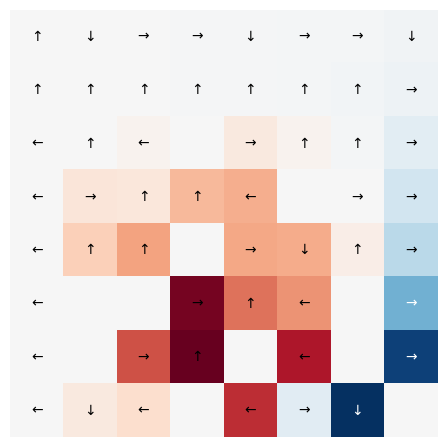

In [37]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(figsize=(5,5))
fig.tight_layout()
im = ax.imshow(q_value_grid, cmap=plt.cm.RdBu)
for i in range(len(q_arrows)):
    for j in range(len(q_arrows[0])):
        if not is_terminal(i, j, custom_map):
            text = ax.text(j, i, q_arrows[i, j], ha="center", va="center", color="white" if q_value_grid[i, j] > 0.35 else 'black')
ax.axis('off')
plt.savefig('q_learning_arrow_heatmap.png', bbox_inches='tight', pad_inches=0.0)

In [38]:
# Overlaid image - kind of bad looking blend, does the job
env.reset()
im1 = Image.fromarray(env.render()).resize((400,400))
im2 = Image.open('q_learning_arrow_heatmap.png').convert("RGB").resize((400, 400))
Image.blend(im1, im2, alpha=.6).save('q_learning_arrow_heatmap_overlaid.png')

In [39]:
episode_lens = []
num_test_episodes = 1000
cumulative_reward = 0.0

im_init = Image.blend(Image.fromarray(env.render()).resize((400,400)), im2, alpha=.6)
viz = []

for test in range(num_test_episodes):
    state, _ = env.reset()
    terminated = False
    len_ = 0
    while not terminated:
        len_ += 1
        action = q_policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        if terminated and reward == 0.0:
            reward = -1.0
        cumulative_reward += reward

        if test == 57:
            rendered = env.render()
            viz.append(Image.blend(Image.fromarray(rendered).resize((400,400)), im2, alpha=.6))
    episode_lens.append(len_)
        
print(f'Total reward possible: {num_test_episodes}')
print(f'Total accumulated reward: {cumulative_reward}')
im_init.save("q_policy.gif", save_all=True, append_images=viz, duration=0.5*(len(viz) + 1), loop=0)
print(f'Average episode len: {sum(episode_lens) / len(episode_lens)}')

Total reward possible: 1000
Total accumulated reward: 1000.0
Average episode len: 149.249
